In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


# Toxic Comment Classification Challenge

This notebook explores the toxic comment classification competition hosted on Kaggle by cjadams et al. (2017). The goal of this project is to classify comments from Wikipedia’s talk page edits into six possible types of comment toxicity (toxic, severe_toxic, obscene, threat, insult, identity_hate).

This is a good project to explore the use of RNNs and determine if we can improve upon and apply some of the techniques we developed earlier in the course.

# Exploratory Data Analysis (EDA)

First, we will examine the data to determine which model is most suitable.

In [9]:
import pandas as pd

# Load zipped CSVs directly
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

# Check shapes
print('Train:', train.shape)
print('Test:', test.shape)

# Preview
train.head()

Train: (159571, 8)
Test: (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We can see that there is a lot of data here. There are 159571 rows in the train dataset with eight columns. In the test dataset, there are 153164 rows and only two columns.

* id: Comment ID - unique per comment, so irrelevant to any machine learning.
* comment_text - this is likely what we will want to learn on.
* The following columns are all attributes of toxicity, which we will predict on:
  * toxic
  * severe_toxic
  * obscene
  * threat
  * insult
  * identity_hate

What we first want to do is check for any nulls. This will let us know if we need to do any preprocessing later.

In [4]:
print(train.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


From the output above, we can see that there are no null values, so we do not need to perform any preprocessing on null values.

Next, we want to check the distribution of character length and word count. This will help us understand how the data is organized and identify any outliers.

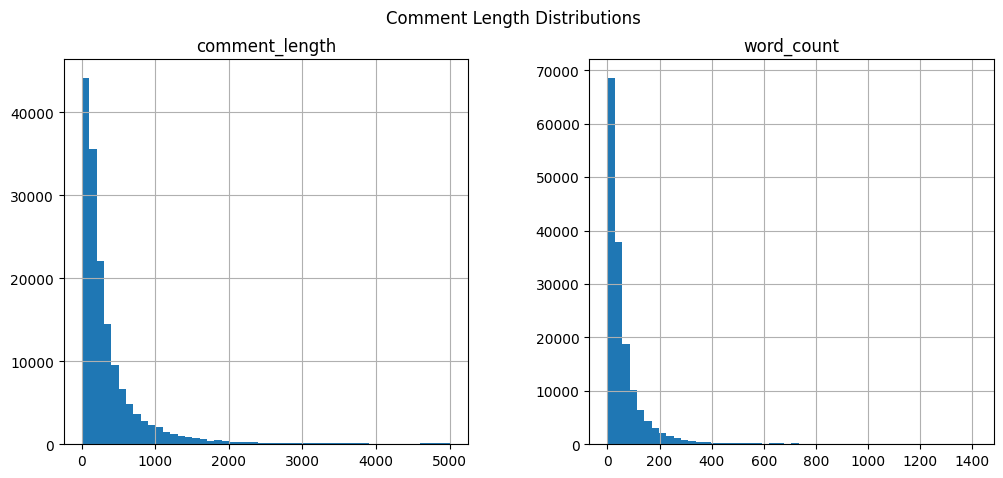

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

train['comment_length'] = train['comment_text'].apply(len)
train['word_count'] = train['comment_text'].apply(lambda x: len(x.split()))

train[['comment_length', 'word_count']].hist(bins=50, figsize=(12,5))
plt.suptitle('Comment Length Distributions')
plt.show()

As shown above, the comment length is heavily skewed towards shorter lengths, and the number of words follows a similar pattern. There's a long tail where comments and words drag out.

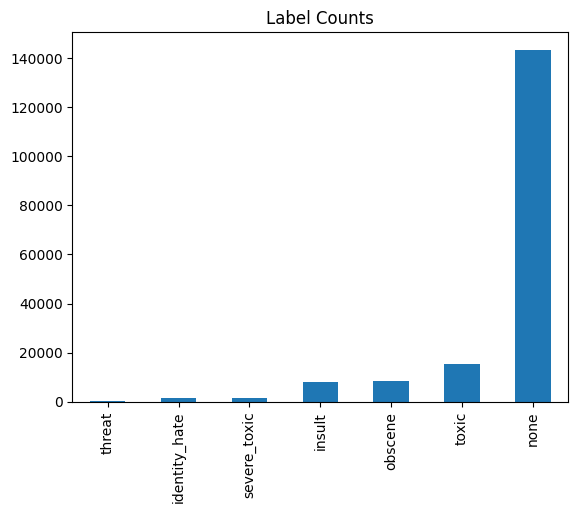

In [7]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

label_counts = train[labels].sum()
none_count = (train[labels].sum(axis=1) == 0).sum()
label_counts['none'] = none_count


label_counts.sort_values().plot(kind='bar', title='Label Counts')
plt.show()

From this, we can see that our data is heavily skewed towards being non-toxic (no label). We need to be careful when training our model that it doesn't overshoot.

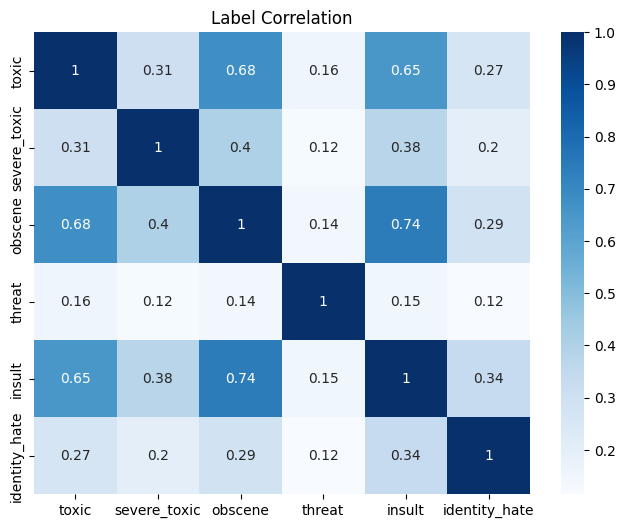

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(train[labels].corr(), annot=True, cmap='Blues')
plt.title('Label Correlation')
plt.show()

From the correlation matrix, we can see that many values are correlated, for example, obscene and insult, or toxic and insult. It looks as if they are not collinear as they are still not 0.9 or above.

In [17]:
from wordcloud import WordCloud

toxic_text = ' '.join(train[train['toxic']==1]['comment_text'])
non_toxic_text = ' '.join(train[train['toxic']==0]['comment_text'])

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.imshow(WordCloud(max_words=100).generate(toxic_text))
# plt.axis('off')
# plt.title('Toxic Comments')

# plt.subplot(1,2,2)
# plt.imshow(WordCloud(max_words=100).generate(non_toxic_text))
# plt.axis('off')
# plt.title('Non-Toxic Comments')

# plt.show()

I have chosen not to display the word cloud here due to the obscene words that are visible. However, there is a clear difference between the toxic comments and the non-toxic comments.

In [9]:
train['label_count'] = train[labels].sum(axis=1)

print("\n✅ Example Non-Toxic Comments:\n", train[train['label_count']==0]['comment_text'].sample(2).values)
print("\n✅ Example Toxic Comments:\n", train[train['label_count']>=1]['comment_text'].sample(2).values)


✅ Example Non-Toxic Comments:
 ["List of programs \n\nIt is not fair that you had to delete the list of all programs that have been issued by the channel, if that's very important, because without that list, you would have no idea what they transmit on the channel, because then the information would be confusing and meaningless, and it is important to clarify what kind of programs are currently issued or issued in the Latin American version of the channel has to be done halgo, it's not fair!"
 "Ah, but you claim the Extraordinary Rendition article actually said it that was `legal'. It certainly doesn't say that. But, hey, we all make mistakes. ... al  bin Baloney (Hows my driving?)"]

✅ Example Toxic Comments:
 ['"\n\nall above text is used as proof. do you want me to sue you guys? you call yourselves ""THE FREE ENCYCLOPEDIA"".\nWhat kind of bull crap is that? anybody can edit? yeah except for when you block them! You should be glad i havent taken action yet, because i was personally 

In [23]:
train['has_mention'] = train['comment_text'].str.contains(r'@\w+')
print(train['has_mention'].sum(), "comments contain mentions (@...)")

718 comments contain mentions (@...)


In [24]:
train['has_hashtag'] = train['comment_text'].str.contains(r'#\w+')
print(train['has_hashtag'].sum(), "comments contain hashtags (#...)")

3156 comments contain hashtags (#...)


Ok, so we can see some punctuation in the comments. We need to do some data pre-processing.

# Preprocessing Data

To prepare the data for our models, we will use lower case text, remove any URLs, remove any mentions or hastags, remove punctuation and digits as well as extra whitespace.

In [27]:
import re
import string

def clean_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text) # Remove mentions and hashtags
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\\n', ' ', text)  # Remove literal \n
    text = re.sub(r'\\r', ' ', text)  # Remove literal \r
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace (new lines, tabs, etc.)
    return text

# Apply to the dataset
train['clean_comment'] = train['comment_text'].apply(clean_text)
test['clean_comment'] = test['comment_text'].apply(clean_text)

In [34]:
print("\n✅ Example Non-Toxic Comments:\n", train[train['label_count']==0]['clean_comment'].sample(2).values)
print("\n✅ Example Toxic Comments:\n", train[train['label_count']>=1]['clean_comment'].sample(2).values)


✅ Example Non-Toxic Comments:
 ['quote from wikistress there are users who simply cannot and do not want to write npov articles users who want to delete relevant information users who are notoriously antisocial and so on we think these are the types of users we do not really want on wikipedia and a few have been banned however while many wikipedians tend to write slightly pov articles about subjects that are near and dear to their hearts most of them can be worked with'
 'doctor who articles im not sure quite what youre doing but it looks fairly drastic perhaps we ought to establish a consensus on wtwho andor wpmos first see my userpage for details']

✅ Example Toxic Comments:
 ['bite me redux really stop leaving silly messages for people if you dont want them to talk back to you'
 'utc he ate the crabs off of phaedriels rotten cunt may']


In [35]:
comment_lengths = train['clean_comment'].apply(lambda x: len(x.split()))
comment_lengths.describe()

count    159571.000000
mean         65.535486
std          97.471945
min           0.000000
25%          16.000000
50%          35.000000
75%          73.000000
max        1403.000000
Name: clean_comment, dtype: float64

This will help us determine the optimal max_len when processing the comments into the tokenizer (we need to cover about 95% of comments).

# Plan of Analysis

Based on the Exploratory Data Analysis, it appears that an RNN would be well-suited to analyze the comments. First, we will run a simple model to establish a baseline. After that, we will improve our model using a BiGRU and BiLTSM. 

Since the models are evaluated using the average AUC for each column, we will also use AUC, as well as F1, in our measurements and comparisons between models.

Finally, we will iterate over the best of the three models with some hyperparameter tuning based on what we find.

# Preprocessing Comments¶
To prepare the comments for our models, we need to perform preprocessing first. In this case, we are using the Tokenizer from Keras. 

After tokenization and padding, we will split the training dataset into a test and training set. Splitting the dataset will enable the model to validate its performance.

In [36]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Tokenization and Padding
max_vocab = 15000
max_len = 250 # About two standard deviations from the mean.

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train['clean_comment'])

train_sequences = tokenizer.texts_to_sequences(train['clean_comment'])

X = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(
    X, train[labels], test_size=0.2, random_state=42)

2025-07-20 13:44:14.193804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753019054.501253      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753019054.568234      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Model Architecture
Let us create the model. We will use a very basic RNN. After that, we will compare it to BiGRU and then proceed to BiLTSM. After that, we will iterate over some hyperparameters.

## Simple RNN
In this architecture, we are using the SimpleRNN from Keras with no dropout layers. We are also using things like early stopping so that if the model does not improve, it will stop. We will reduce the learning rate when it plateaus. Finally, we will also save the best model so that we can restore it later for the final results. We will run for a maximum of 15 epochs.

Note that we have six labels (excluding 'none') that we want to predict for.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

simple_model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128),
    SimpleRNN(64),
    Dense(6, activation='sigmoid')
])
simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc'])

simple_model.summary()

2025-07-20 13:45:23.433057: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## BiGRU

Bi-directional Gated Recurrent Units (GRU) are also designed to target the vanishing gradient problem with RNNs. We are running this first, as it should be the most performant algorithm (with fewer parameters). However, it does not handle the long-term dependencies as well as the LSTM.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout

from tensorflow.keras.optimizers import Adam

gru_model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128),
    Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(6, activation='sigmoid')
])

gru_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),  # smaller LR for stability
    metrics=['accuracy', 'auc']
)

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## BiLSTM
BiLSTM, or Bi-directional Long Short-Term Memory, is supposed to capture long-term dependencies in the data. Bi-directional LTSM looks back as well as forward, which should capture toxic comments more effectively as it will look for patterns that a forward-looking LTSM might miss.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(6, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', 'auc'])

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Results and Analysis

Now, it is time to run our models and see if we can improve them. Firstly, we will run the model for the simple RNN. We will then use the confusion matrix and the Area Under the Curve (AUC) to check for the model's accuracy. We will use a combination of F1 score, average AUC, and accuracy to compare the performance of each model (Simple, BiGRU, BiLTSM).

## Simple Model

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

simple_callbacks_list = [
    # This helps stop the model early
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    # Reduces learning rate when plateued
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    # save best model
    ModelCheckpoint(
        filepath='simple_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

simple_history = simple_model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=simple_callbacks_list
)

Epoch 1/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9457 - auc: 0.7046 - loss: 0.1683
Epoch 1: val_loss improved from inf to 0.14206, saving model to simple_model.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 90s 86ms/step - accuracy: 0.9457 - auc: 0.7046 - loss: 0.1683 - val_accuracy: 0.9940 - val_auc: 0.7514 - val_loss: 0.1421 - learning_rate: 0.0010
Epoch 2/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9935 - auc: 0.7545 - loss: 0.1412
Epoch 2: val_loss improved from 0.14206 to 0.14160, saving model to simple_model.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.9935 - auc: 0.7545 - loss: 0.1412 - val_accuracy: 0.9893 - val_auc: 0.7533 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 3/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9830 - auc: 0.7553 - loss: 0.1417
Epoch 3: val_loss did not improve from 0.14160
998/998 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - accuracy: 0.9830 - auc: 0.7553 - loss: 0.1417 - val_accuracy: 0.9825 - val_auc: 0.751

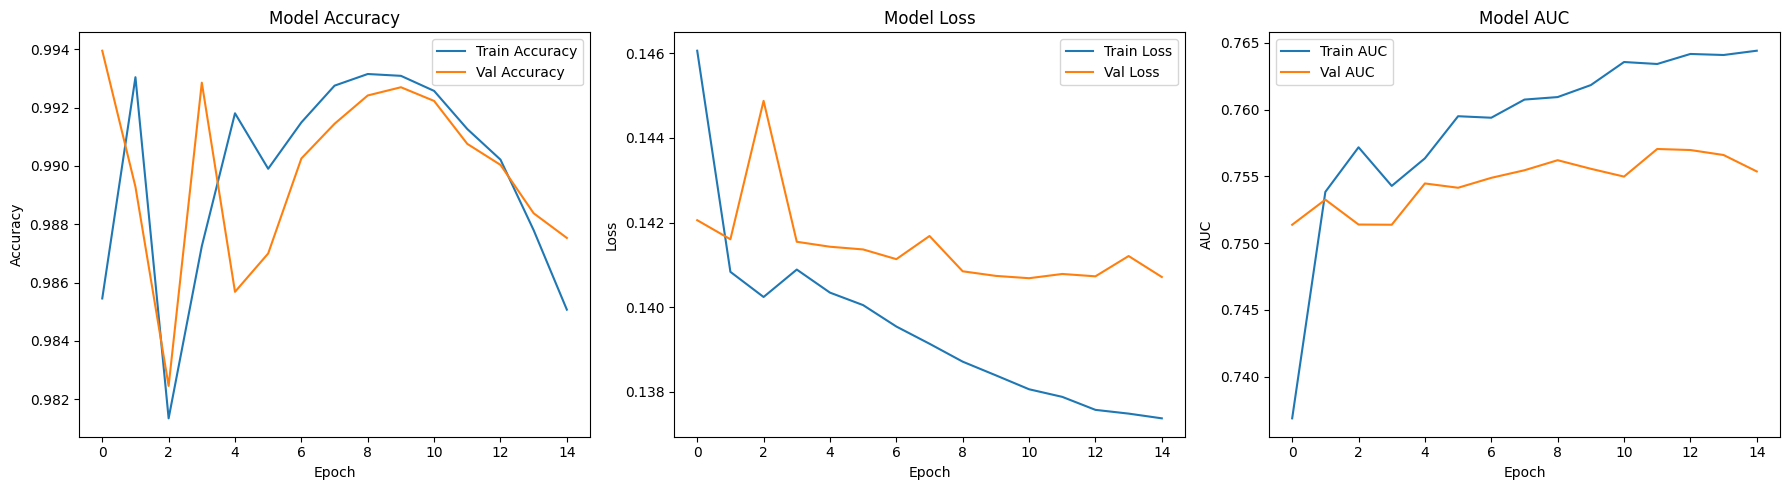

In [42]:
import matplotlib.pyplot as plt

# Create a 1x3 plot layout
plt.figure(figsize=(18, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(simple_history.history['accuracy'], label='Train Accuracy')
plt.plot(simple_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(simple_history.history['loss'], label='Train Loss')
plt.plot(simple_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(simple_history.history['auc'], label='Train AUC')
plt.plot(simple_history.history['val_auc'], label='Val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

From these charts, we can see how accuracy, loss, and AUC evolved. Accuracy took a dive for both the train and validation sets between the 8th and 10th epochs. However, the loss continued to decrease, but the train loss decreased at a faster rate than the validation loss. Finally, we can see that the AUC improved over time.

998/998 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step

Classification Report:
                precision    recall  f1-score   support

        toxic       0.54      0.01      0.02      3056
 severe_toxic       0.83      0.03      0.06       321
      obscene       0.61      0.01      0.02      1715
       threat       0.25      0.01      0.03        74
       insult       0.40      0.01      0.01      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.50      0.01      0.02      7074
    macro avg       0.44      0.01      0.02      7074
 weighted avg       0.51      0.01      0.02      7074
  samples avg       0.00      0.00      0.00      7074



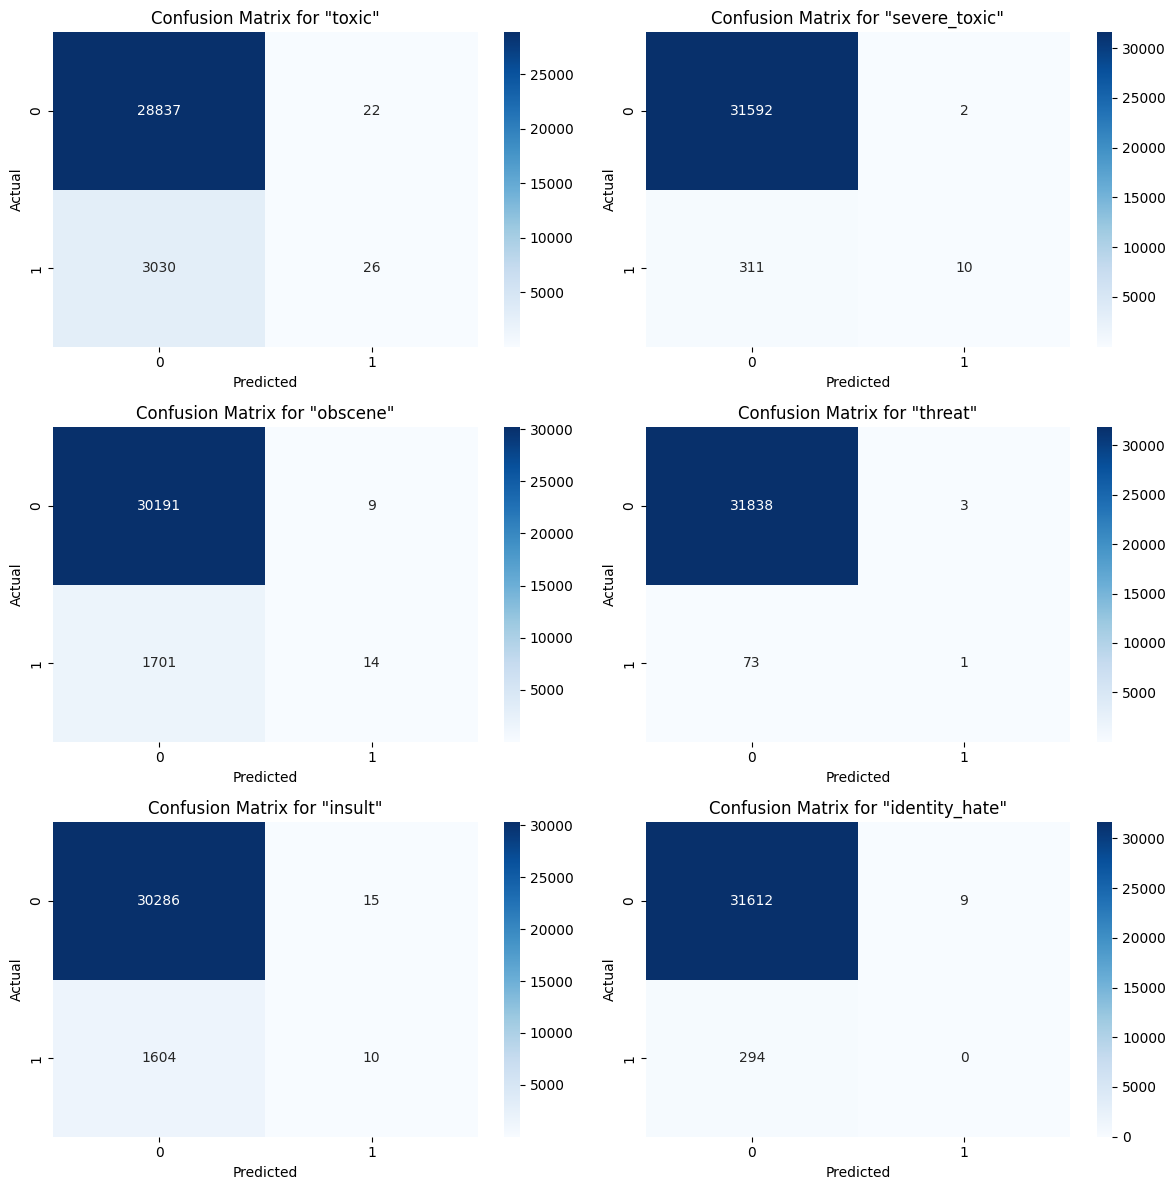

In [51]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on validation set
y_pred_probs = simple_model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 2: Evaluation metrics
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=labels, zero_division=0))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Step 3: Confusion Matrix
for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[label], y_pred[:, i])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for "{label}"')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

What we can notice from this is that the F1 scores are low. In the confusion matrices, we can also see how unbalanced the predictions are.

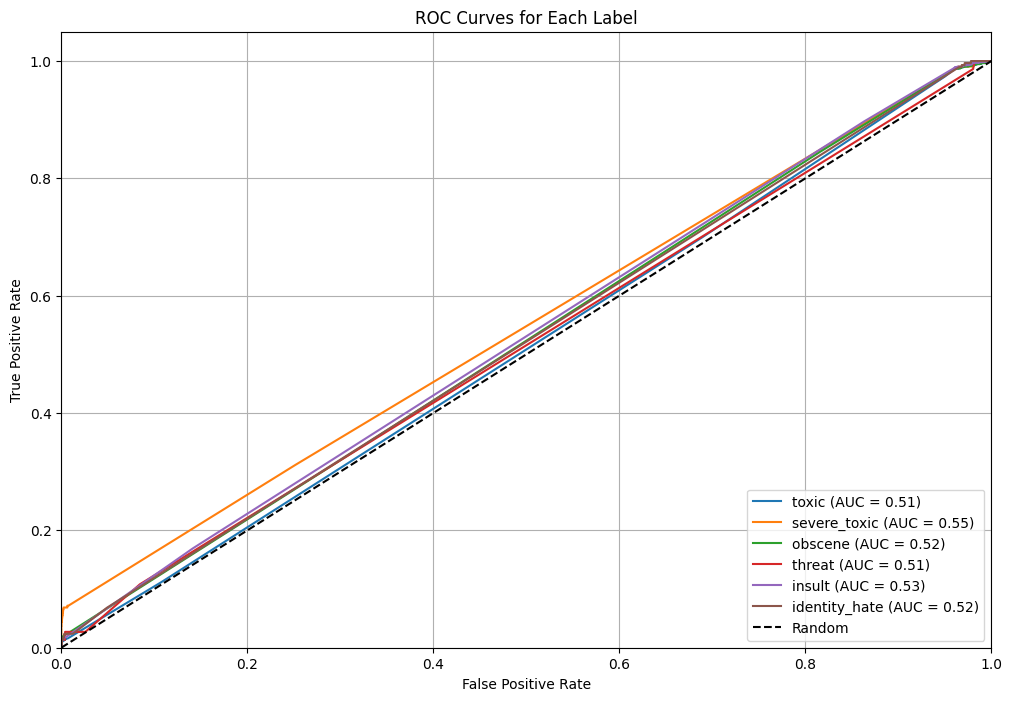

Average AUC is 0.523945852462206.


In [57]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_val[label], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend(loc='lower right')
plt.grid()
plt.show()

auc_score = roc_auc_score(y_val, y_pred_probs, average='macro')
print(f"Average AUC is {auc_score}.")

What we can see from this is that, although the model performed well during training, it is overfitting to the training data. Let us see how it compares to BiGRU.

## BiGRU

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

gru_callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        min_lr=1e-6, 
        verbose=1
    ),
    ModelCheckpoint(
        filepath='gru_model.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    )
]

gru_history = gru_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=gru_callbacks_list
)

Epoch 1/15
190/998 ━━━━━━━━━━━━━━━━━━━━ 5:37 418ms/step - accuracy: 0.9947 - auc: 0.9673 - loss: 0.0578

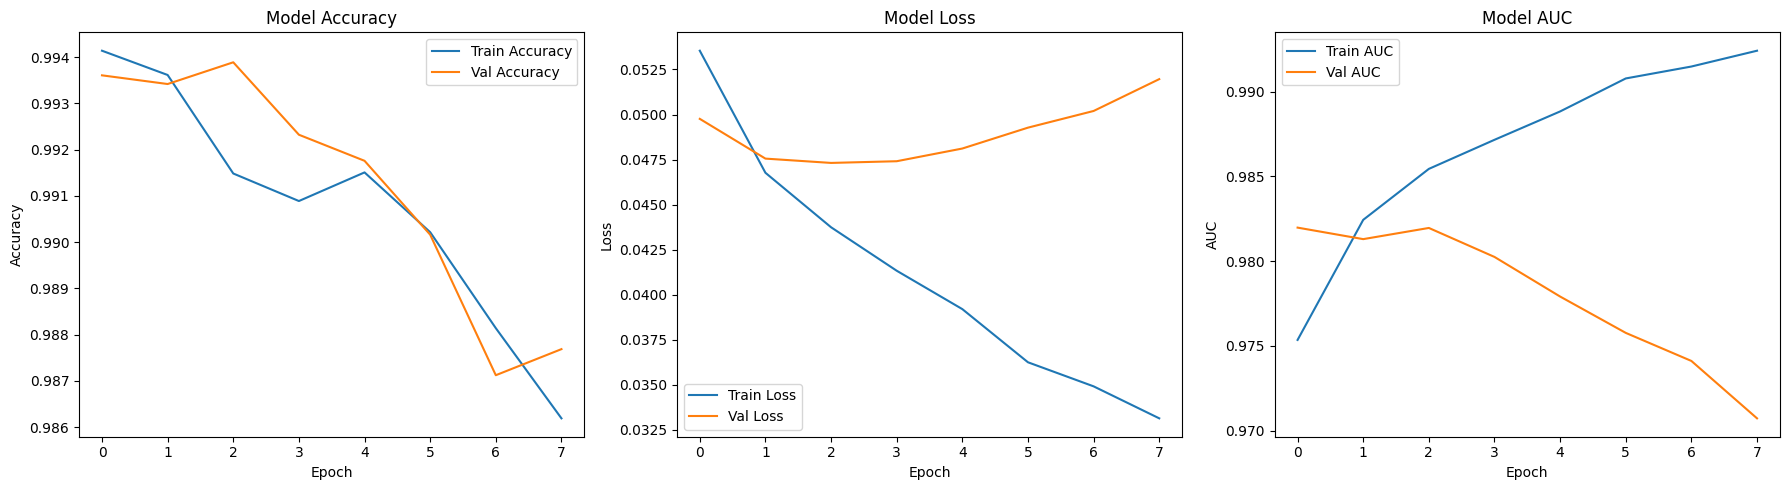

In [6]:
import matplotlib.pyplot as plt

# Create a 1x3 plot layout
plt.figure(figsize=(18, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(gru_history.history['auc'], label='Train AUC')
plt.plot(gru_history.history['val_auc'], label='Val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

These historical graphs differ significantly from the simple model. We can see that accuracy decreased for both training and validation over time. The loss for validation went down and then up, while the loss for training only went down. Finally, AUC for training increased while it decreased for validation. This all shows that we may be overfitting to the training data.

998/998 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step

Classification Report:
                precision    recall  f1-score   support

        toxic       0.82      0.78      0.80      3056
 severe_toxic       0.64      0.17      0.27       321
      obscene       0.84      0.80      0.82      1715
       threat       0.00      0.00      0.00        74
       insult       0.75      0.65      0.70      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.81      0.69      0.74      7074
    macro avg       0.51      0.40      0.43      7074
 weighted avg       0.76      0.69      0.72      7074
  samples avg       0.07      0.06      0.06      7074



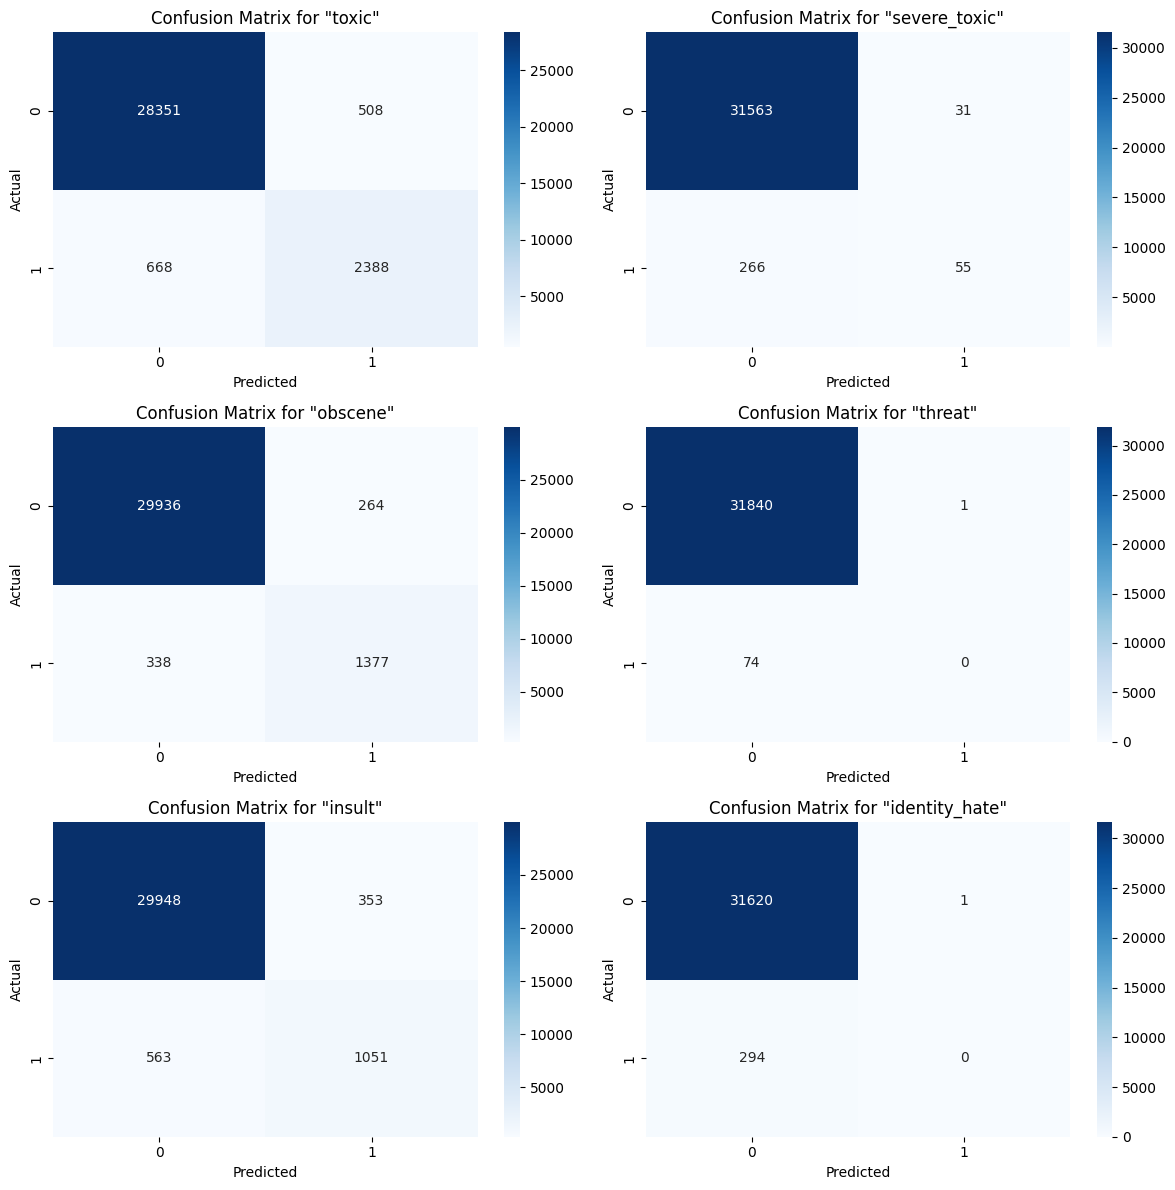

In [7]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on validation set
y_pred_probs_gru = gru_model.predict(X_val)
y_pred_gru = (y_pred_probs_gru > 0.5).astype(int)

# Step 2: Evaluation metrics
print("\nClassification Report:\n", classification_report(y_val, y_pred_gru, target_names=labels, zero_division=0))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Step 3: Confusion Matrix
for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[label], y_pred_gru[:, i])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for "{label}"')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

The F1 scores were, on average, quite good, but we can see that two categories (threat and identity_hate) performed particularly poorly. This is shown in the confusion matrices, where there were no predicted and actual positive hits.

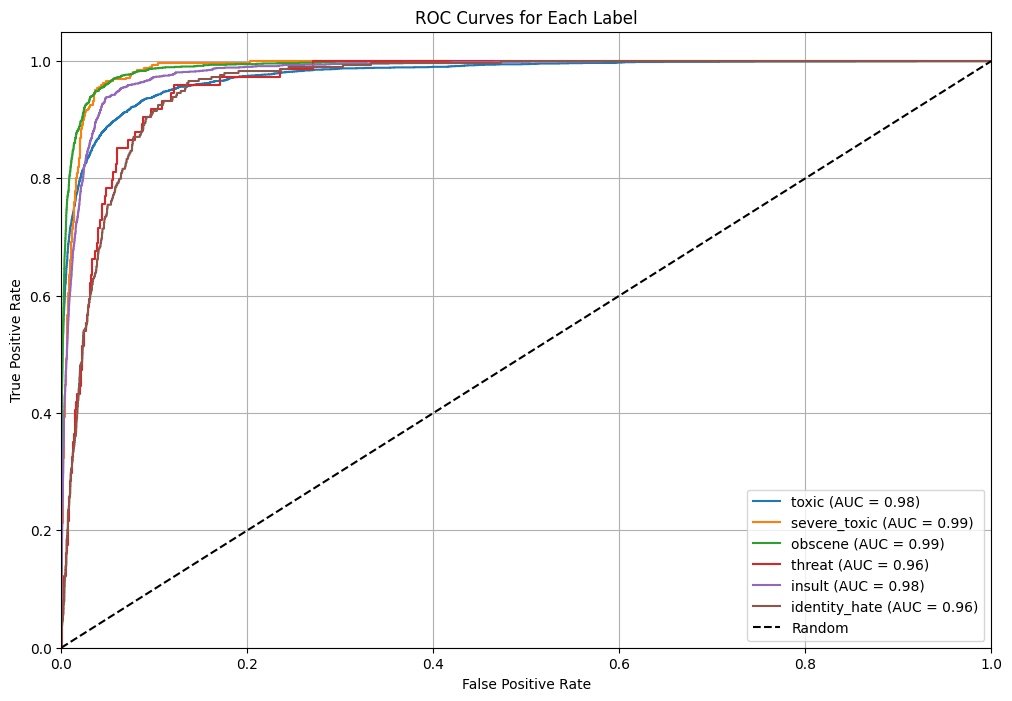

Average AUC is 0.9768308507614915.


In [8]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_val[label], y_pred_probs_gru[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend(loc='lower right')
plt.grid()
plt.show()

auc_score_gru = roc_auc_score(y_val, y_pred_probs_gru, average='macro')
print(f"Average AUC is {auc_score_gru}.")

Overall, the AUC appears to be very good, but this can also be attributed to the skew in the data towards non-toxic comments.

## BiLTSM

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

lstm_callbacks_list = [
    # This helps stop the model early
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    # Reduces learning rate when plateued
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    # save best model
    ModelCheckpoint(
        filepath='lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=lstm_callbacks_list
)

Epoch 1/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9460 - auc: 0.8831 - loss: 0.1122
Epoch 1: val_loss improved from inf to 0.05089, saving model to lstm_model.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 517s 511ms/step - accuracy: 0.9461 - auc: 0.8832 - loss: 0.1121 - val_accuracy: 0.9941 - val_auc: 0.9813 - val_loss: 0.0509 - learning_rate: 0.0010
Epoch 2/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9939 - auc: 0.9822 - loss: 0.0464
Epoch 2: val_loss improved from 0.05089 to 0.04834, saving model to lstm_model.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 502s 503ms/step - accuracy: 0.9939 - auc: 0.9822 - loss: 0.0464 - val_accuracy: 0.9941 - val_auc: 0.9819 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 3/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9942 - auc: 0.9859 - loss: 0.0426
Epoch 3: val_loss improved from 0.04834 to 0.04832, saving model to lstm_model.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 510s 511ms/step - accuracy: 0.9942 - auc: 0.9859 - loss: 0.0

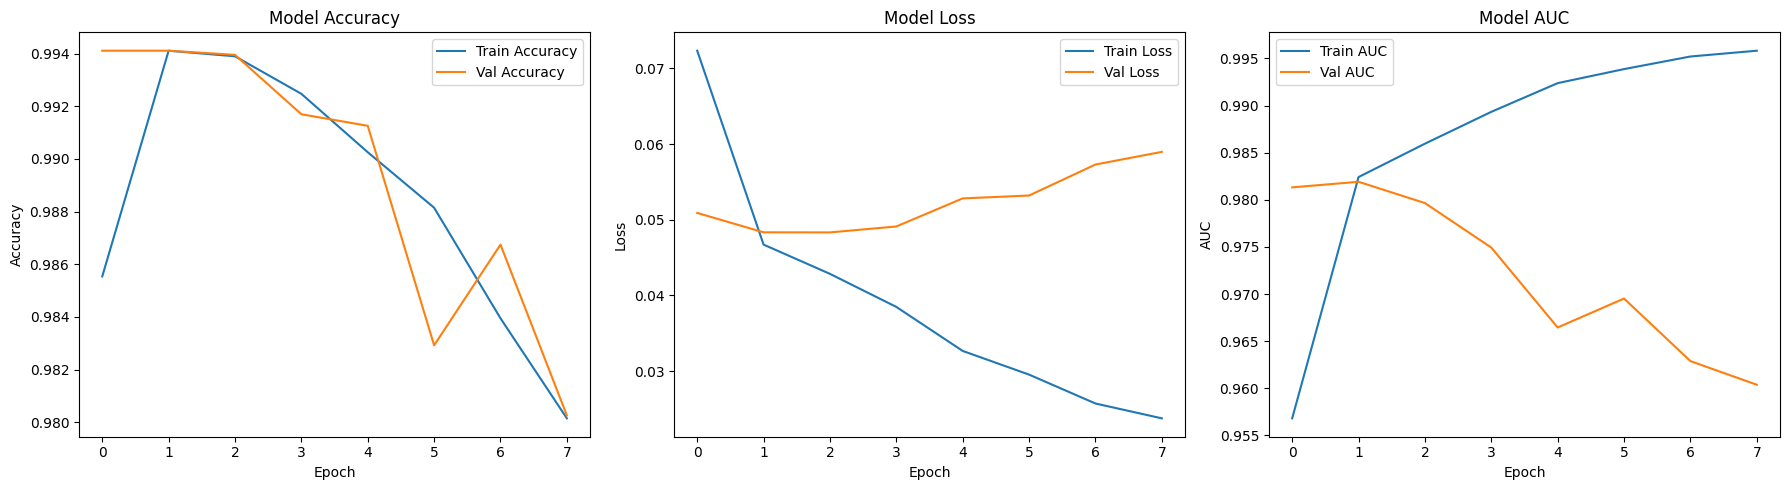

In [11]:
import matplotlib.pyplot as plt

# Create a 1x3 plot layout
plt.figure(figsize=(18, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(lstm_history.history['auc'], label='Train AUC')
plt.plot(lstm_history.history['val_auc'], label='Val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

What we can see here is again a similar story to the BiGRU model history. We can see that the accuracy for both training and validation decreased over time. Again, the train loss decreased while the validation loss increased, which suggests overfitting. Finally, we can see that the validation AUC decreased while the training AUC increased.

998/998 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step

Classification Report:
                precision    recall  f1-score   support

        toxic       0.87      0.72      0.79      3056
 severe_toxic       0.72      0.12      0.20       321
      obscene       0.81      0.82      0.82      1715
       threat       0.00      0.00      0.00        74
       insult       0.75      0.67      0.70      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.82      0.67      0.74      7074
    macro avg       0.53      0.39      0.42      7074
 weighted avg       0.78      0.67      0.71      7074
  samples avg       0.06      0.06      0.06      7074



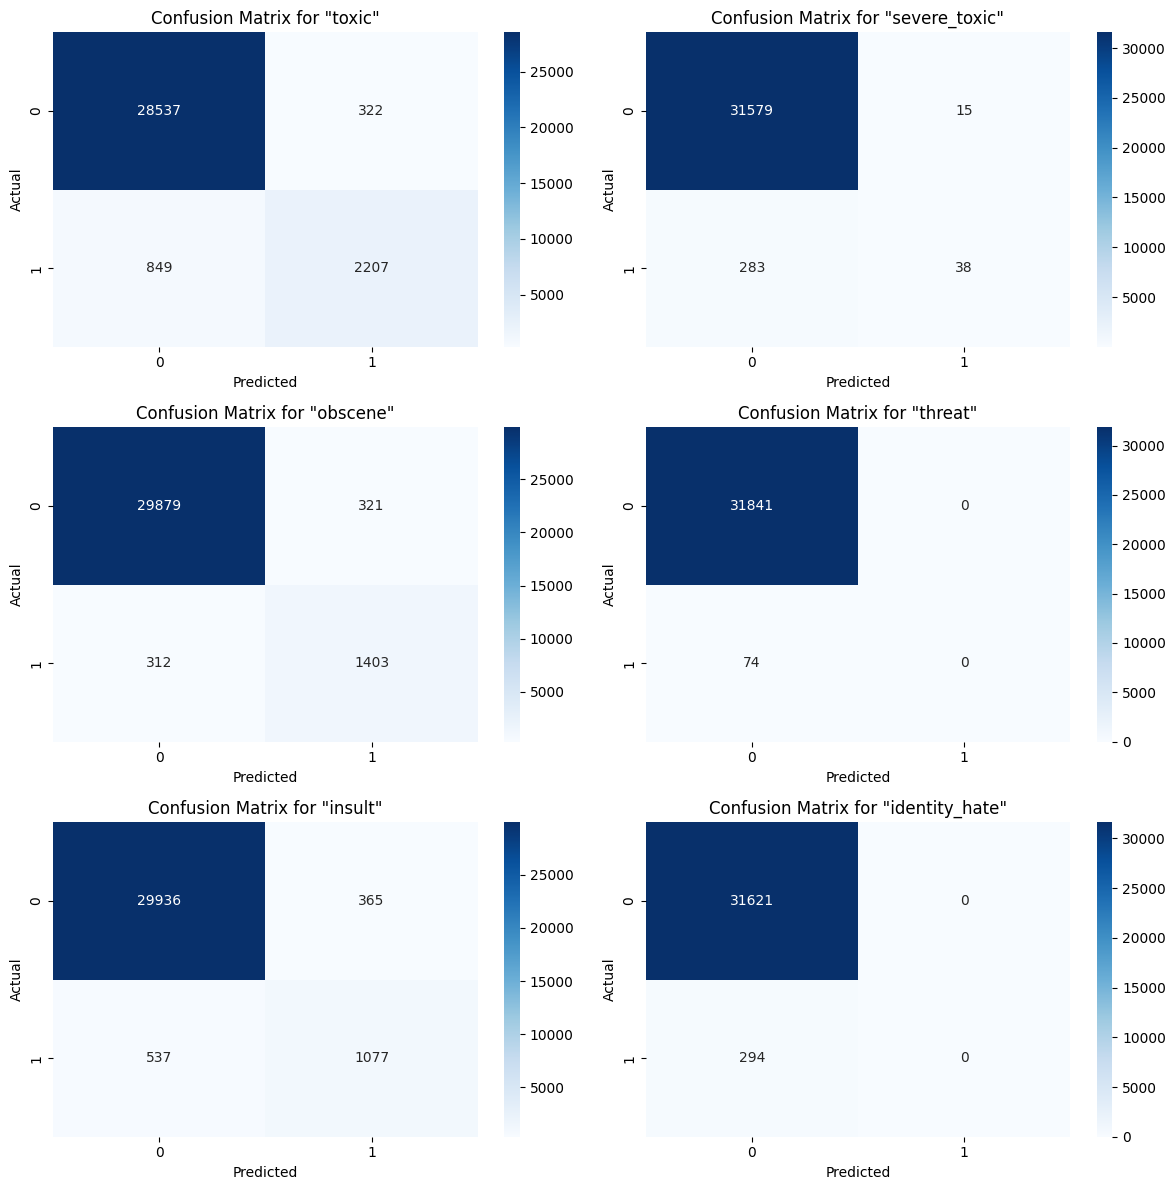

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on validation set
y_pred_probs_lstm = lstm_model.predict(X_val)
y_pred_lstm = (y_pred_probs_lstm > 0.5).astype(int)

# Step 2: Evaluation metrics
print("\nClassification Report:\n", classification_report(y_val, y_pred_lstm, target_names=labels, zero_division=0))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Step 3: Confusion Matrix
for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[label], y_pred_lstm[:, i])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for "{label}"')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

We can observe the same issue as the BiGRU, where the same two columns exhibit the same problem. This suggests we need to do some model tuning/data augmentation.

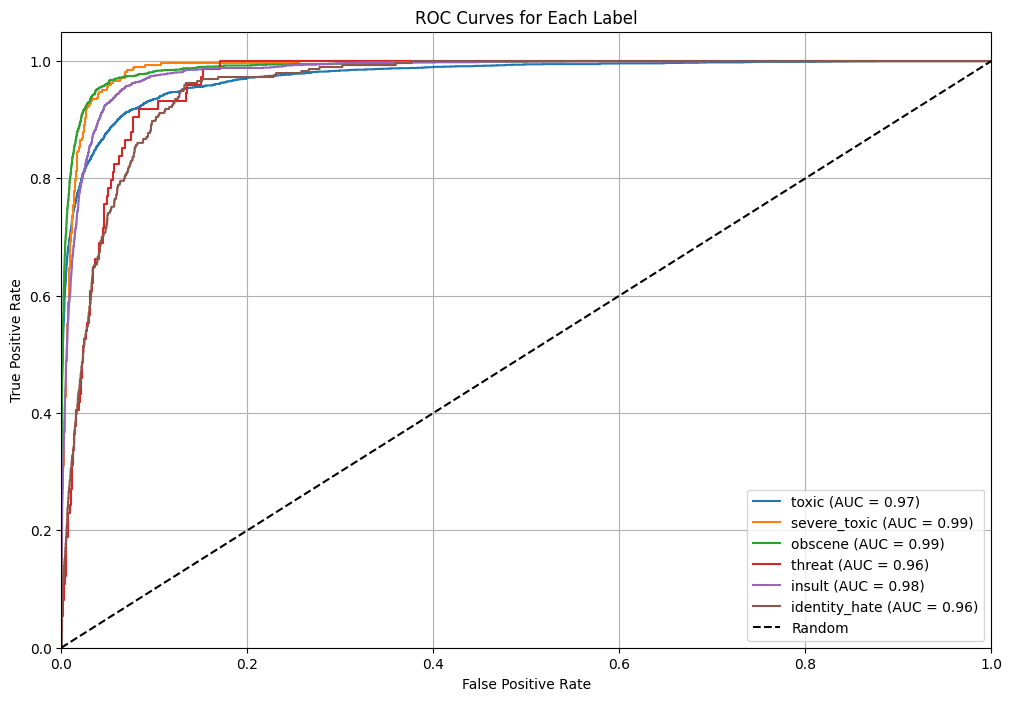

Average AUC is 0.9763142331967337.


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_val[label], y_pred_probs_lstm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend(loc='lower right')
plt.grid()
plt.show()

auc_score_lstm = roc_auc_score(y_val, y_pred_probs_lstm, average='macro')
print(f"Average AUC is {auc_score_lstm}.")

Based on the AUC, the BiGRU appears to be slightly better so far (0.9768 vs 0.9763). So, we'll use that model to tune accordingly.

## BiGRU Tuning - BinaryFocalCrossentropy

According to Lin et al. (2018), applying a focal factor helps down-weight easy examples and focus more on complex examples (which is what is happening in this case). So, let us try it out.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam

gru_model_v2 = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128),
    Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(6, activation='sigmoid')
])

gru_model_v2.compile(
    loss=BinaryFocalCrossentropy(apply_class_balancing=True),
    optimizer=Adam(learning_rate=0.0005),  # smaller LR for stability
    metrics=['accuracy', 'auc']
)

gru_model_v2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

gru_callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        min_lr=1e-6, 
        verbose=1
    ),
    ModelCheckpoint(
        filepath='gru_model_v2.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    )
]

gru_history_v2 = gru_model_v2.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=gru_callbacks_list
)

Epoch 1/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8236 - auc: 0.8331 - loss: 0.0163
Epoch 1: val_loss improved from inf to 0.00544, saving model to gru_model_v2.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 551s 539ms/step - accuracy: 0.8237 - auc: 0.8332 - loss: 0.0163 - val_accuracy: 0.9928 - val_auc: 0.9802 - val_loss: 0.0054 - learning_rate: 5.0000e-04
Epoch 2/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9781 - auc: 0.9826 - loss: 0.0052
Epoch 2: val_loss improved from 0.00544 to 0.00483, saving model to gru_model_v2.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 534s 535ms/step - accuracy: 0.9781 - auc: 0.9826 - loss: 0.0052 - val_accuracy: 0.9864 - val_auc: 0.9864 - val_loss: 0.0048 - learning_rate: 5.0000e-04
Epoch 3/15
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9744 - auc: 0.9881 - loss: 0.0046
Epoch 3: val_loss improved from 0.00483 to 0.00473, saving model to gru_model_v2.keras
998/998 ━━━━━━━━━━━━━━━━━━━━ 535s 535ms/step - accuracy: 0.9744 - auc: 0.98

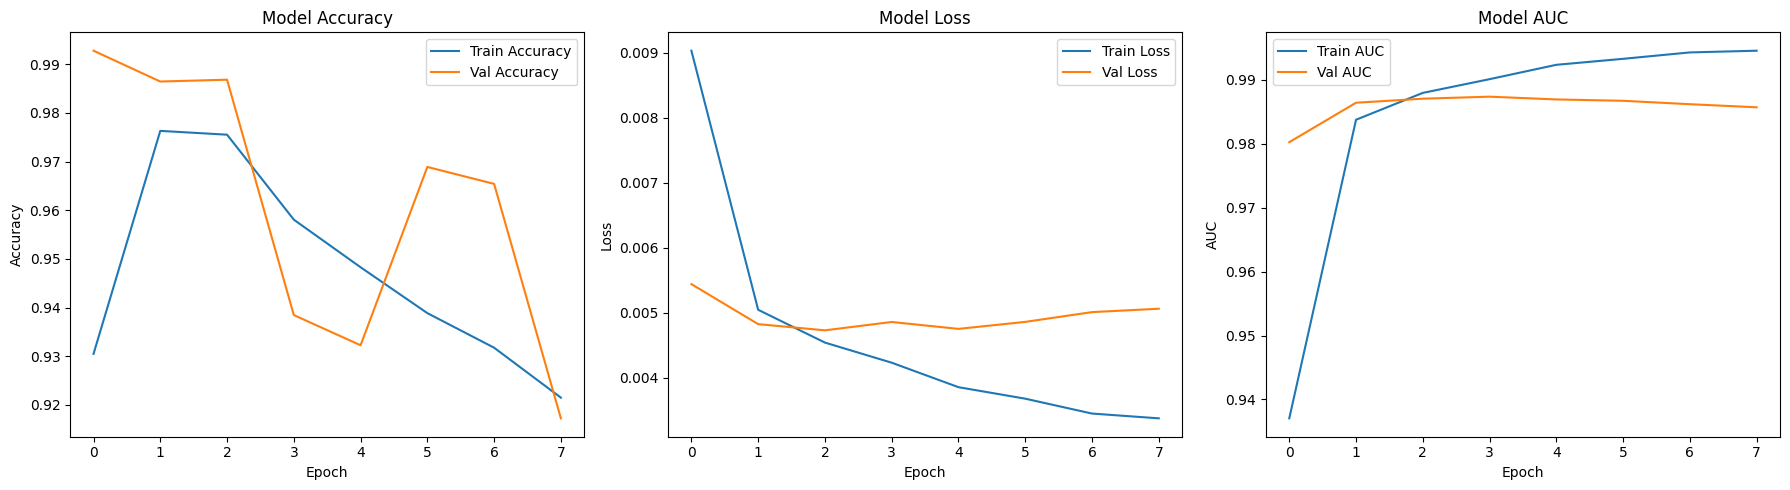

In [5]:
import matplotlib.pyplot as plt

# Create a 1x3 plot layout
plt.figure(figsize=(18, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(gru_history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(gru_history_v2.history['loss'], label='Train Loss')
plt.plot(gru_history_v2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(gru_history_v2.history['auc'], label='Train AUC')
plt.plot(gru_history_v2.history['val_auc'], label='Val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

What we can see here is that the accuracy is inconsistent. For validation data, it jumps up and down. We can also see that the loss has remained relatively flat for validation, but for train, it dropped sharply. Lastly, we can see that the AUC improved significantly for training but showed only marginal improvements for validation.

998/998 ━━━━━━━━━━━━━━━━━━━━ 57s 56ms/step

Classification Report:
                precision    recall  f1-score   support

        toxic       0.92      0.64      0.76      3056
 severe_toxic       0.72      0.04      0.08       321
      obscene       0.93      0.64      0.76      1715
       threat       0.00      0.00      0.00        74
       insult       0.84      0.50      0.63      1614
identity_hate       0.75      0.01      0.02       294

    micro avg       0.91      0.55      0.68      7074
    macro avg       0.69      0.30      0.37      7074
 weighted avg       0.88      0.55      0.66      7074
  samples avg       0.06      0.05      0.05      7074



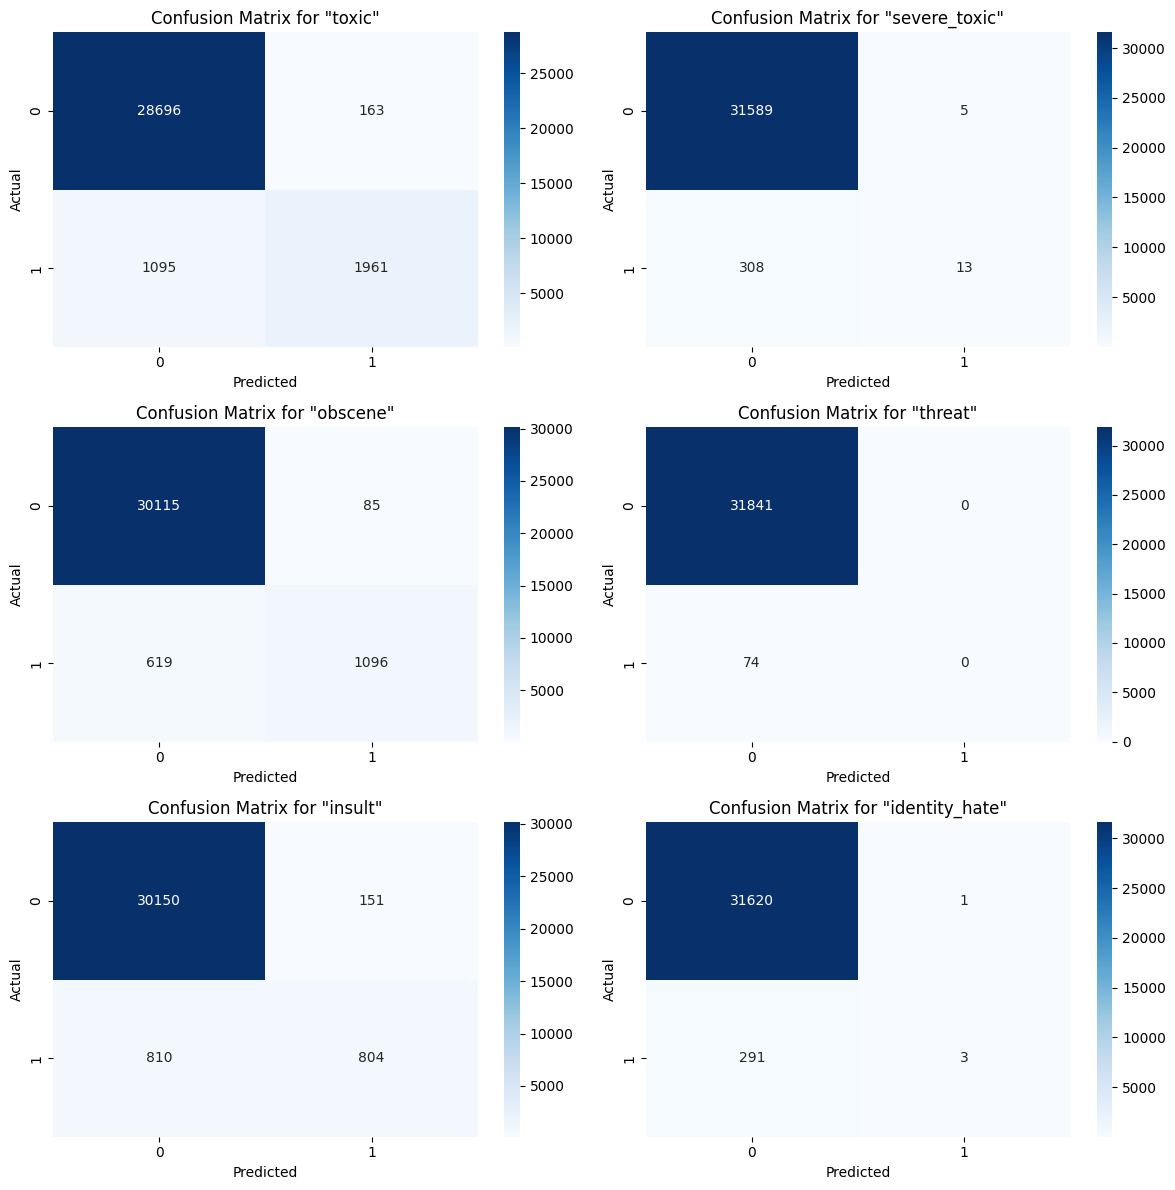

In [6]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on validation set
y_pred_probs_gru2 = gru_model_v2.predict(X_val)
y_pred_gru2 = (y_pred_probs_gru2 > 0.5).astype(int)

# Step 2: Evaluation metrics
print("\nClassification Report:\n", classification_report(y_val, y_pred_gru2, target_names=labels, zero_division=0))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Step 3: Confusion Matrix
for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[label], y_pred_gru2[:, i])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for "{label}"')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

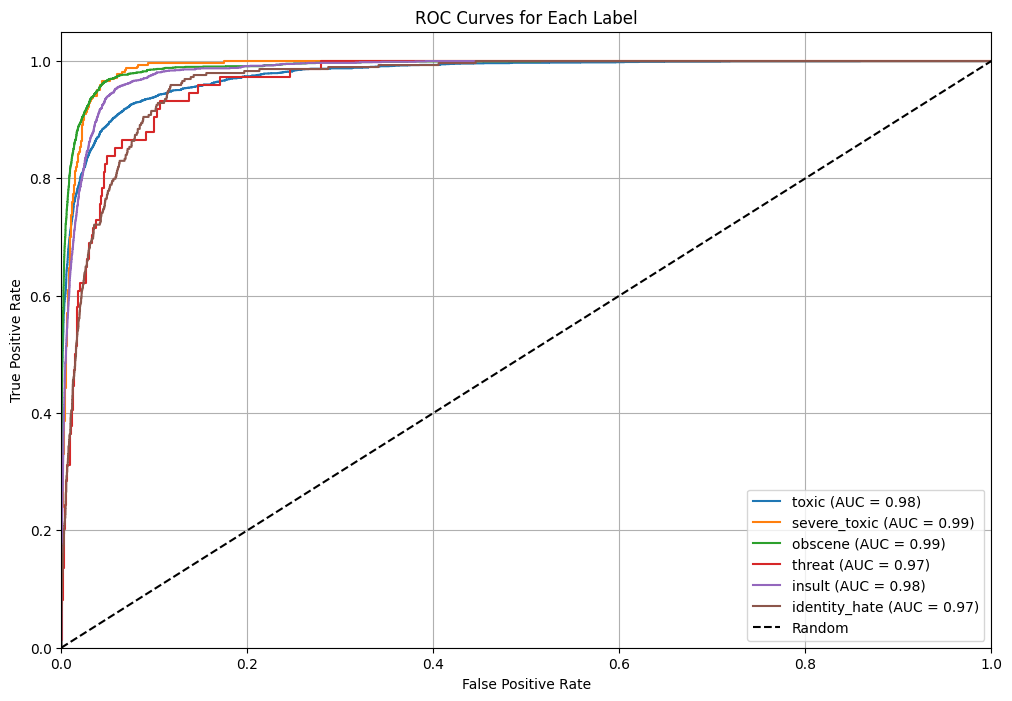

Average AUC is 0.9787393035485703.


In [8]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_val[label], y_pred_probs_gru2[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend(loc='lower right')
plt.grid()
plt.show()

auc_score_gru2 = roc_auc_score(y_val, y_pred_probs_gru2, average='macro')
print(f"Average AUC is {auc_score_gru2}.")

What we can see is that this offers a slight improvement over the previous BiGRU. Let's submit this version of the RNN and find out how it performs!

In [27]:
test_sequences = tokenizer.texts_to_sequences(test['clean_comment'])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Predict probabilities
predictions = gru_model_v2.predict(test_padded)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'toxic': predictions[:,0],
    'severe_toxic': predictions[:,1],
    'obscene': predictions[:,2],
    'threat': predictions[:,3],
    'insult': predictions[:,4],
    'identity_hate': predictions[:,5]
})

# Preview
submission.head()

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 266s 56ms/step


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.827803,0.297685,0.690590,0.195749,0.621238,0.284722
1,0000247867823ef7,0.031789,0.007862,0.024142,0.018007,0.019672,0.017195
2,00013b17ad220c46,0.114689,0.026500,0.080542,0.045143,0.078515,0.054251
3,00017563c3f7919a,0.065256,0.012140,0.042064,0.017843,0.040953,0.022405
4,00017695ad8997eb,0.069497,0.014823,0.056033,0.021548,0.031717,0.021504


In [28]:
# Save to CSV
submission.to_csv('submission.csv', index=False)

This gave a score of 0.96665, which is quite far below the top scores.



# Conclusion and Learning



In [1]:
results = {
    'Model': ['Simple Model', 'LSTM Model', 'GRU Model', 'GRU Model v2'],
    'AUC': [auc_score, auc_score_lstm, auc_score_gru, auc_score_gru2]
}

df_result = pd.DataFrame(results).sort_values(by=['AUC'], ascending=False)
df_result

,Model,AUC
3,GRU Model v2,0.978739
2,GRU Model,0.976831
1,LSTM Model,0.976314
0,Simple Model,0.523946


## Discussion and Learnings

From the table above, we can see that BiGRU with a focal factor helped boost the algorithm performance. What we also see is that the simple RNN model performed much worse than the Bi-directional GRU and LSTM models. 

Although I expected the LSTM to perform better than the GRU, I also has in the back of my mind that there could be some overfitting on the training data. This was clearly the case across all the models trained in this exercise.

The actual competition test results came in with 0.96665, which shows that it still underperformed. What we also notice with all the models is the F1 scores for identity_hate and threat. These were super hard for the models to pick up.

In [4]:
from sklearn.metrics import classification_report
import pandas as pd

# List of model predictions and their names
model_preds = {
    'GRU Model v2': y_pred_gru2,
    'GRU Model': y_pred_gru,
    'LSTM Model': y_pred_lstm,
    'Simple Model': y_pred
}

# Collect f1 scores
f1_results = []

for model_name, y_pred_model in model_preds.items():
    report = classification_report(y_val, y_pred_model, target_names=labels, output_dict=True, zero_division=0)
    f1_threat = report.get('threat', {}).get('f1-score', 0)
    f1_identity = report.get('identity_hate', {}).get('f1-score', 0)
    
    f1_results.append({
        'Model': model_name,
        'Threat F1': f1_threat,
        'Identity Hate F1': f1_identity
    })

# Create a DataFrame
f1_df = pd.DataFrame(f1_results)
f1_df = f1_df.sort_values(by='Threat F1', ascending=False).reset_index(drop=True)
f1_df

,Model,Threat F1,Identity Hate F1
0,Simple Model,0.025641,0.000000
1,GRU Model v2,0.000000,0.020134
2,GRU Model,0.000000,0.000000
3,LSTM Model,0.000000,0.000000


Examining the F1 scores above, we can see that although the AUC scores are extreme, these models fail to capture the nuances in the toxic comments. What's interesting is that even though the AUC for the simple model is low (0.52), it still managed to capture threats better than any of the others (0.026 compared to 0 for the rest).

## Improvements

There are still some more optimizations we can make to improve the models:
* Use a pre-trained word embedding like GloVe (Global Vectors for Word Representation).
* Create a custom weighted Focal Loss that will take into account the minority cases.
* Oversample by duplicating rare class rows. Oversampling will make it less rare and may help the models learn more effectively.

## Conclusion

The model performed pretty poorly on the Kaggle competition. The poor performance is likely due to overfitting on the training data as well as completely ignoring the minority cases, as seen above for threats and identity hate.

Overall, it has been a valuable project to learn about RNNs and apply some more advanced RNNs, such as the Bi-directional GRU and Bi-directional LSTM. However, given the low F1 scores for threats and identity hate, these models would not be recommended for identifying nuance in the toxicity.

# References

Aitken, A. M. (2025). Natural Language Processing with Disaster Tweets, 2. Retrieved 07/08/2025 from https://www.kaggle.com/code/alexandermaitken/natural-language-processing-with-disaster-tweets

cjadams, Sorensen, J., Elliott, J., Dixon, L., McDonald, M., nithum, & Cukierski, W. (2017). Toxic comment classification challenge, 1. Retreieved 07/08/2025 from https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge

Lin, T.-Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2018). Focal loss for dense object detection (arXiv:1708.02002v2) [Preprint]. arXiv. https://doi.org/10.48550/arXiv.1708.02002

You can find a copy of the notebook in my Github: https://github.com/alexmaitken/csca5642-final